In [1]:
#!/usr/bin/env python3
# -*- coding:utf-8 -*-

In [2]:
import pandas as pd
import numpy as np

### Settings

The first setting `time` determines how many time steps the model will run through. Arbitrary values `EXPRESSIONS_POSITIVE` and `EXPRESSIONS_NEGATIVE` are temporary settings that substitute other agents in the model and provide emotional input to the field once at the first time step; the first number represents agents communicating positive emotions to the field, the latter negative emotions.

In [3]:
TIME = 20

EXPRESSIONS_POSITIVE = 15
EXPRESSIONS_NEGATIVE = 4

These settings set the valence and arousal baselines for the agents, `VALENCE_BASE` and `AROUSAL_BASE`, and the arousal threshold `AR_THRESHOLD` at which agents communicate their emotions.

In [4]:
VALENCE_BASE = 0.2 # b
AROUSAL_BASE = 0.2 # d
AR_THRESHOLD = 0.3 # tau

The following parameters are constant variables or lists of variables that determine the decay of emotions in agents and the amplitude of stochastic influences on these emotions, `AGENT_DECAY` and `AGENT_AMP` (first values in the lists affect valence, the second arousal), the immediate down-regulation of emotions after their expression `DOWN_REG`, the coefficients `VALENCE_COEFF` and `AROUSAL_COEFF` that are used to describe how the emotional charge of the field change valence and arousal in agents (the first value in the list is value 0, the second is value 1, and so on), the emotional charge of the field at the start of the simulation `FIELD_CHARGE`, the rate of decay of the field `FIELD_DECAY`, and the impact value of the field on the agents `FIELD_IMPACT`.

In [5]:
AGENT_DECAY = [0.3, # gamma_v
               0.9] # gamma_a
AGENT_AMP = [0.3, # A_v
             0.3] # A_a
DOWN_REG = 0.4 # k
VALENCE_COEFF = [0,  # b_0
                 1,  # b_1
                 0,  # b_2
                 -1] # b_3
AROUSAL_COEFF = [0.05, # d_0
                 0.5,  # d_1
                 0.5,  # d_2
                 0.5]  # d_3

FIELD_CHARGE = 0   # h
FIELD_DECAY = 0.7  # gamma_h
FIELD_IMPACT = 0.1 # s

### Entities

The following classes define the two entities in the model, agents and the field.

Note: stochastic factors were removed for the purpose of testing the emotion dynamics of agents.

In [6]:
class Agent:
    '''
    Each agent represents one forum user and is defined by its emotional state
    that is stored in the valence and arousal variables. Valence indicates
    whether their emotional state is positive or negative, while arousal
    indicates the strength of that emotion.
    '''
    def __init__(self):
        self.identity = None
        self.valence = VALENCE_BASE
        self.arousal = AROUSAL_BASE
        self.threshold = AR_THRESHOLD
        self.valence_history = []
        self.arousal_history = []

    def perception(self, field):
        '''
        This method describes how agents perceive their field, how the field
        affects their emotional states, and returns the changed emotion
        variable given the input field variable and a stochastic component
        represented by a random number. The impact of the latter is determined
        by the amplitude parameter of the agent.
        '''
        v_change = field * (VALENCE_COEFF[0]
                            + VALENCE_COEFF[1] * self.valence
                            + VALENCE_COEFF[2] * self.valence ** 2
                            + VALENCE_COEFF[3] * self.valence ** 3)
        a_change = np.sign(field) * (AROUSAL_COEFF[0]
                                     + AROUSAL_COEFF[1] * self.arousal
                                     + AROUSAL_COEFF[2] * self.arousal ** 2
                                     + AROUSAL_COEFF[3] * self.arousal ** 3)

#        v_stoch = AGENT_AMP[0] * np.random.randint(-100, 100) / 100
#        a_stoch = AGENT_AMP[1] * np.random.randint(-100, 100) / 100

        self.valence = v_change + self.valence# + v_stoch
        self.arousal = a_change + self.arousal# + a_stoch

    def expression(self):
        '''
        This method describes the information agents express to the field and
        when. When their arousal reaches their internal threshold value, they
        communicate the sign of their valence, the information whether they
        are in a positive or negative emotional state. After they communicate
        this by storing the information in the expression variable, their
        valence and arousal are both immediately down-regulated.
        '''
        if self.arousal >= self.threshold:
            emotion = np.sign(self.valence)
            self.valence = (self.valence - VALENCE_BASE) \
                           * DOWN_REG + VALENCE_BASE
            self.arousal = (self.arousal - AROUSAL_BASE) \
                           * DOWN_REG + AROUSAL_BASE
        else:
            emotion = None

        return emotion

    def relaxation(self):
        '''
        This methods describes how the the emotional state of agents relaxes
        towards its baseline over time according to the internal decay
        paramater, independently of whether or not an emotion was expressed.
        '''
        v_relax = (-1) * AGENT_DECAY[0] * (self.valence - VALENCE_BASE)
        a_relax = (-1) * AGENT_DECAY[1] * (self.arousal - AROUSAL_BASE)
        self.valence += v_relax
        self.arousal += a_relax

    def data_collection(self):
        self.valence_history.append(round(self.valence, 2))
        self.arousal_history.append(round(self.arousal, 2))

Note: since the test runs only simulate one agent, agent expressions are artificially induced at the first time step.

In [7]:
class Field:
    '''
    Each communication field allows the agents of the model to communicate
    with each other by storing their emotional expressions. Fields represent
    discussion threads that forum users can participate in, one at a time, and
    that affect their emotional state. It requires the input of the initial
    emotional charge of the field, its impact on agents, and the decay of this
    impact over time.
    '''
    def __init__(self):
        self.charge = FIELD_CHARGE
        self.positive_charge = 0
        self.negative_charge = 0
        self.field_history = [self.charge]

    def communication(self, time):
        '''
        This methods describes how the field variable changes depending on
        user participation and the emotional information they put in. It takes
        two lists of agent expression variables as input, namely a list of all
        positive expressions and a list of all negative expressions.
        '''
        if time < 1:
            positive_number = EXPRESSIONS_POSITIVE
            negative_number = EXPRESSIONS_NEGATIVE
        else:
            positive_number = 0
            negative_number = 0

        self.positive_charge = (FIELD_IMPACT * positive_number
                                - FIELD_DECAY * self.positive_charge)
        self.negative_charge = (FIELD_IMPACT * negative_number
                                - FIELD_DECAY * self.negative_charge)
        self.charge = self.positive_charge# + self.negative_charge

    def data_collection(self):
        self.field_history.append(round(self.charge, 2))

### Schedule

The following function describes the order by which the model is run, starting by creating a set number of instances of the agent class and the field, processing the agent methods first, then the field methods and lastly collecting and visualizing data on both.

Note: the method describing the expression of emotions was excluded for testing purposes

In [8]:
def start_simulation(time):
    '''
    This function runs the model using the given settings. At every time step,
    each agent may or may not communicate its emotions by expressing them and
    storing them in the field, and then adjusting its emotional state
    accordingly. Afterwards, the field takes action by calculating its new
    emotional charge given previous agent expressions. The output of the
    function is a list of dataframes containing the individual valence and
    arousal histories of the agents and the field charge history.
    '''
    agent = Agent()
    field = Field()

    for step in range(time):
        agent.perception(field.charge)
        agent.data_collection()
        agent.relaxation()
        field.communication(step)
        field.data_collection()

    v_list = []
    a_list = []
    f_list = []

    v_list.append(agent.valence_history)
    a_list.append(agent.arousal_history)
    f_list.append(field.field_history)

    v_data = pd.DataFrame(v_list)
    a_data = pd.DataFrame(a_list)
    f_data = pd.DataFrame(f_list)

    data = {"valence": v_data, "arousal": a_data, "field": f_data}

    valence_plot = data["valence"].transpose().plot(color="#1f77b4")
    valence_plot.set(xlabel="Time".capitalize())
    valence_plot.legend(["Agent valence"])

    arousal_plot = data["arousal"].transpose().plot(color="#d62728")
    arousal_plot.set(xlabel="Time".capitalize())
    arousal_plot.legend(["Agent arousal"])

    field_plot = data["field"].transpose().plot(color="#2ca02c")
    field_plot.set(xlabel="Time".capitalize())
    field_plot.legend(["Field charge"])

### Running the model

Here the model is run with the above settings. At the current state it does not produce the expected output. The source of this failure remains to be determined, but is expected to lie in the method determining the decay of the field charge.

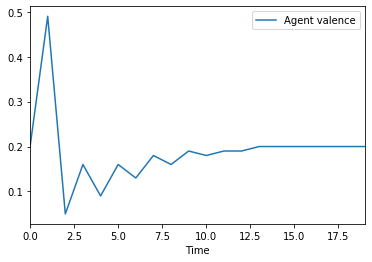

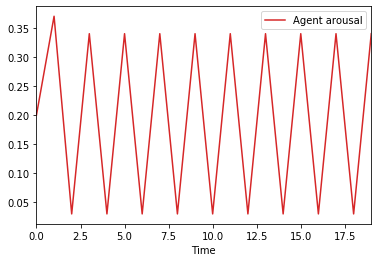

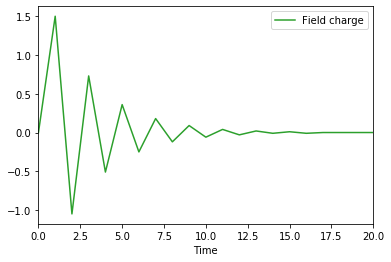

In [10]:
start_simulation(TIME)